**Libraries**

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
from datetime import date, timedelta


In [2]:
from sklearn.cluster import KMeans


**Reading Data**

In [3]:
path = '/kaggle/input/coronavirusdataset/'
patient_data_path = path + 'patient.csv'
route_data_path = path + 'route.csv'
time_data_path = path + 'time.csv'

df_patient = pd.read_csv(patient_data_path)
df_route = pd.read_csv(route_data_path)
df_time = pd.read_csv(time_data_path)

**Looking into patient data**

In [4]:
df_patient.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
0,1,female,1984.0,China,filtered at airport,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released
1,2,male,1964.0,Korea,filtered at airport,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released
2,3,male,1966.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released
3,4,male,1964.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released
4,5,male,1987.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released


1.  **id** the ID of the patient (n-th confirmed patient)
2.  **sex** the sex of the patient
3.  **birth_year** the birth year of the patient
4.  **country** the country of the patient
5.  **region** the region of the patient
6.  **group** the collective infection
7.  **infection_reason** the reason of infection
8.  **infection_order** the order of infection
9.  **infected_by** the ID of who has infected the patient
10. **contact_number** the number of contacts with people
11. **confirmed_date** the date of confirmation
12. **released_date** the date of discharge
13. **deceased_date** the date of decease
14. **state** isolated / released / deceased

In [5]:
df_patient.isna().sum()


id                     0
sex                 5345
birth_year          5358
country                1
region              5357
group               5683
infection_reason    5620
infection_order     5731
infected_by         5696
contact_number      5716
confirmed_date         1
released_date       5728
deceased_date       5743
state                  1
dtype: int64

In [6]:
df_patient['birth_year'] = df_patient.birth_year.fillna(0.0).astype(int)
df_patient['birth_year'] = df_patient['birth_year'].map(lambda val: val if val > 0 else np.nan)

In [7]:
df_patient.confirmed_date = pd.to_datetime(df_patient.confirmed_date)
daily_count = df_patient.groupby(df_patient.confirmed_date).id.count()
accumulated_count = daily_count.cumsum()



In [8]:
df_patient['age'] = 2020 - df_patient['birth_year'] 

In [9]:
import math
def group_age(age):
    if age >= 0: # not NaN
        if age % 10 != 0:
            lower = int(math.floor(age / 10.0)) * 10
            upper = int(math.ceil(age / 10.0)) * 10 - 1
            return f"{lower}-{upper}"
        else:
            lower = int(age)
            upper = int(age + 9) 
            return f"{lower}-{upper}"
    return "Unknown"


df_patient["age_range"] = df_patient["age"].apply(group_age)

In [10]:
df_patient.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state,age,age_range
0,1,female,1984.0,China,filtered at airport,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released,36.0,30-39
1,2,male,1964.0,Korea,filtered at airport,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released,56.0,50-59
2,3,male,1966.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released,54.0,50-59
3,4,male,1964.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released,56.0,50-59
4,5,male,1987.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released,33.0,30-39


In [11]:
patient=df_patient

**Preprocessing**

In [12]:
date_cols = ["confirmed_date", "released_date", "deceased_date"]
for col in date_cols:
    patient[col] = pd.to_datetime(patient[col])

In [13]:
patient["time_to_release_since_confirmed"] = patient["released_date"] - patient["confirmed_date"]

patient["time_to_death_since_confirmed"] = patient["deceased_date"] - patient["confirmed_date"]
patient["duration_since_confirmed"] = patient[["time_to_release_since_confirmed", "time_to_death_since_confirmed"]].min(axis=1)
patient["duration_days"] = patient["duration_since_confirmed"].dt.days
age_ranges = sorted(set([ar for ar in patient["age_range"] if ar != "Unknown"]))
patient["state_by_gender"] = patient["state"] + "_" + patient["sex"]


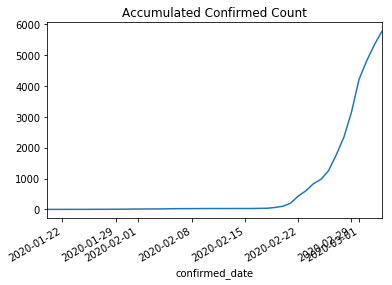

In [14]:
accumulated_count.plot()
plt.title('Accumulated Confirmed Count');

**Current State of Patient**

In [15]:
infected_patient = patient.shape[0]
rp = patient.loc[patient["state"] == "released"].shape[0]
dp = patient.loc[patient["state"] == "deceased"].shape[0]
ip = patient.loc[patient["state"]== "isolated"].shape[0]
rp=rp/patient.shape[0]
dp=dp/patient.shape[0]
ip=ip/patient.shape[0]
print("The percentage of recovery is "+ str(rp*100) )
print("The percentage of deceased is "+ str(dp*100) )
print("The percentage of isolated is "+ str(ip*100) )


The percentage of recovery is 0.693721817551162
The percentage of deceased is 0.39889004509191817
The percentage of isolated is 98.89004509191814


In [16]:
states = pd.DataFrame(patient["state"].value_counts())
states["status"] = states.index
states.rename(columns={"state": "count"}, inplace=True)

fig = px.pie(states,
             values="count",
             names="status",
             title="Current state of patients",
             template="seaborn")
fig.update_traces(rotation=90, pull=0.05, textinfo="value+percent+label")
fig.show()

**People who released**

In [17]:
released = df_patient[df_patient.state == 'released']
released.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,...,released_date,deceased_date,state,age,age_range,time_to_release_since_confirmed,time_to_death_since_confirmed,duration_since_confirmed,duration_days,state_by_gender
0,1,female,1984.0,China,filtered at airport,NaN,visit to Wuhan,1.0,NaN,45.0,...,2020-02-06,NaT,released,36.0,30-39,17 days,NaT,17 days,17.0,released_female
1,2,male,1964.0,Korea,filtered at airport,NaN,visit to Wuhan,1.0,NaN,75.0,...,2020-02-05,NaT,released,56.0,50-59,12 days,NaT,12 days,12.0,released_male
2,3,male,1966.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,16.0,...,2020-02-12,NaT,released,54.0,50-59,17 days,NaT,17 days,17.0,released_male
3,4,male,1964.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,95.0,...,2020-02-09,NaT,released,56.0,50-59,13 days,NaT,13 days,13.0,released_male
4,5,male,1987.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,31.0,...,2020-03-02,NaT,released,33.0,30-39,32 days,NaT,32 days,32.0,released_male


**People who are in isolated state**

In [18]:
isolated_state = df_patient[df_patient.state == 'isolated']
isolated_state.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,...,released_date,deceased_date,state,age,age_range,time_to_release_since_confirmed,time_to_death_since_confirmed,duration_since_confirmed,duration_days,state_by_gender
24,25,female,1946.0,Korea,capital area,NaN,contact with patient,2.0,27.0,12.0,...,NaT,NaT,isolated,74.0,70-79,NaT,NaT,NaT,NaN,isolated_female
25,26,male,1968.0,Korea,capital area,NaN,contact with patient,1.0,27.0,0.0,...,NaT,NaT,isolated,52.0,50-59,NaT,NaT,NaT,NaN,isolated_male
26,27,female,1982.0,China,capital area,NaN,visit to China,1.0,NaN,40.0,...,NaT,NaT,isolated,38.0,30-39,NaT,NaT,NaT,NaN,isolated_female
28,29,male,1938.0,Korea,capital area,NaN,contact with patient,4.0,83.0,117.0,...,NaT,NaT,isolated,82.0,80-89,NaT,NaT,NaT,NaN,isolated_male
29,30,female,1952.0,Korea,capital area,NaN,contact with patient,5.0,29.0,27.0,...,NaT,NaT,isolated,68.0,60-69,NaT,NaT,NaT,NaN,isolated_female


**Patient who died**

In [19]:
dead = df_patient[df_patient.state == 'deceased']
dead.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,...,released_date,deceased_date,state,age,age_range,time_to_release_since_confirmed,time_to_death_since_confirmed,duration_since_confirmed,duration_days,state_by_gender
37,38,female,1963.0,Korea,Daegu,NaN,NaN,NaN,NaN,NaN,...,NaT,2020-02-23,deceased,57.0,50-59,NaT,5 days,5 days,5.0,deceased_female
53,54,male,1963.0,Korea,Gyeongsangbuk-do,Cheongdo Daenam Hospital,NaN,NaN,NaN,NaN,...,NaT,2020-02-23,deceased,57.0,50-59,NaT,4 days,4 days,4.0,deceased_male
54,55,male,1961.0,Korea,Gyeongsangbuk-do,Cheongdo Daenam Hospital,NaN,NaN,NaN,NaN,...,NaT,2020-02-23,deceased,59.0,50-59,NaT,4 days,4 days,4.0,deceased_male
103,104,male,1957.0,Korea,Gyeongsangbuk-do,Cheongdo Daenam Hospital,NaN,NaN,NaN,NaN,...,NaT,2020-02-19,deceased,63.0,60-69,NaT,-1 days,-1 days,-1.0,deceased_male
106,107,male,1953.0,Korea,Gyeongsangbuk-do,Cheongdo Daenam Hospital,NaN,NaN,NaN,NaN,...,NaT,2020-02-24,deceased,67.0,60-69,NaT,3 days,3 days,3.0,deceased_male


**Age distribution of the released**

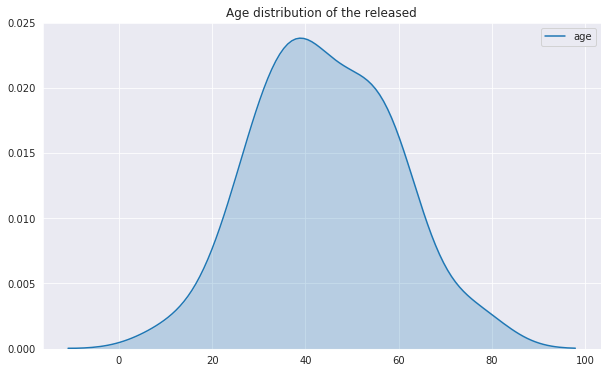

In [20]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the released")
sns.kdeplot(data=released['age'], shade=True)

**Age distribution of isolated person**

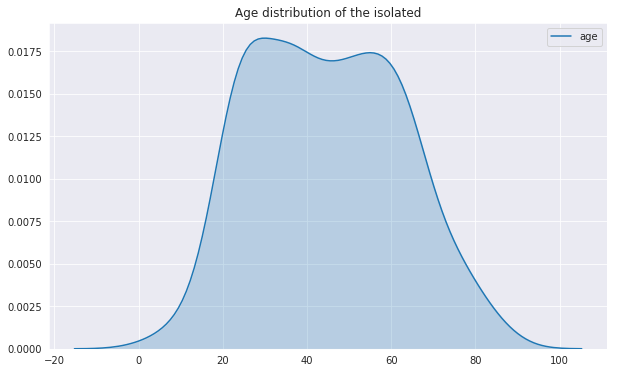

In [21]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the isolated")
sns.kdeplot(data=isolated_state['age'], shade=True)

**Age distribution of death**

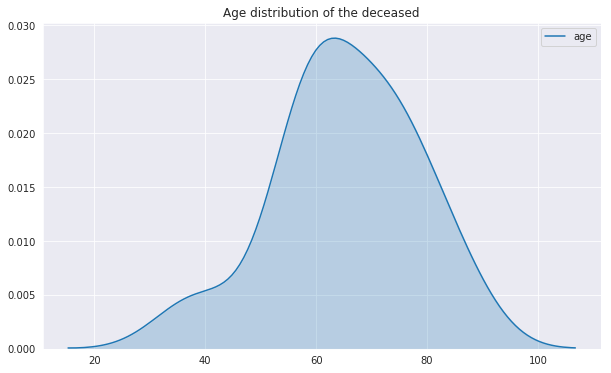

In [22]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the deceased")
sns.kdeplot(data=dead['age'], shade=True)

In [23]:
male_dead = dead[dead.sex=='male']
female_dead = dead[dead.sex=='female']

**Age distribution of death by gender**

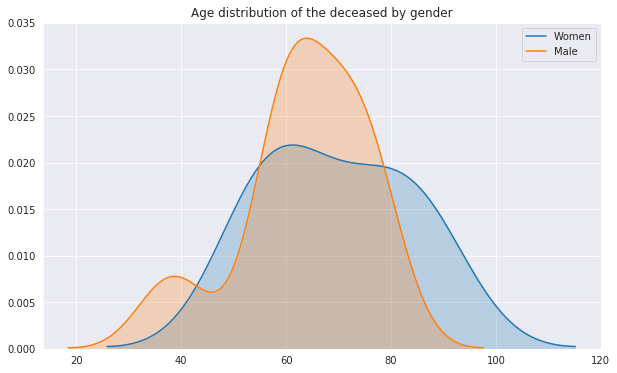

In [24]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the deceased by gender")
sns.kdeplot(data=female_dead['age'], label="Women", shade=True)
sns.kdeplot(data=male_dead['age'],label="Male" ,shade=True)



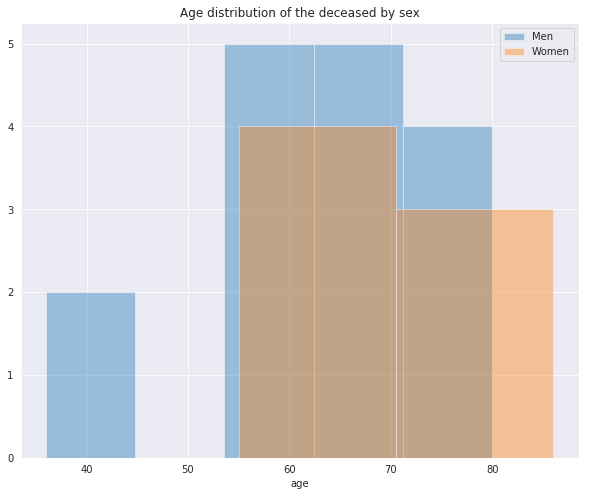

In [25]:
plt.figure(figsize=(10,8))
sns.set_style("darkgrid")
sns.distplot(a=male_dead['age'], label="Men", kde=False)
sns.distplot(a=female_dead['age'], label="Women", kde=False)
plt.title("Age distribution of the deceased by sex")
plt.legend()

**Comparison of released and deceased by age**

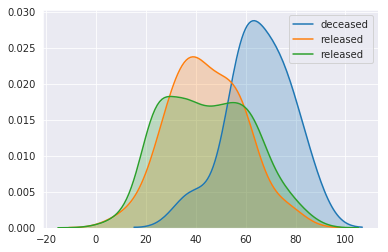

In [26]:
sns.kdeplot(data=dead['age'],label='deceased', shade=True)
sns.kdeplot(data=released['age'],label='released', shade=True)
sns.kdeplot(data=isolated_state['age'],label='released', shade=True)

**Death by gender**

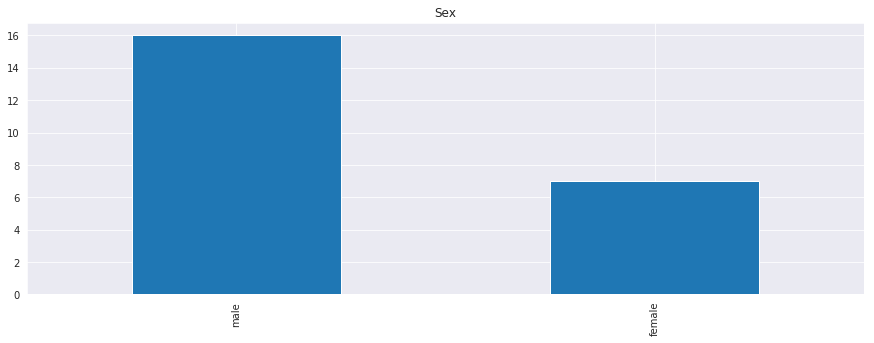

In [27]:
plt.figure(figsize=(15, 5))
plt.title('Sex')
dead.sex.value_counts().plot.bar();

**Reason for the infection**

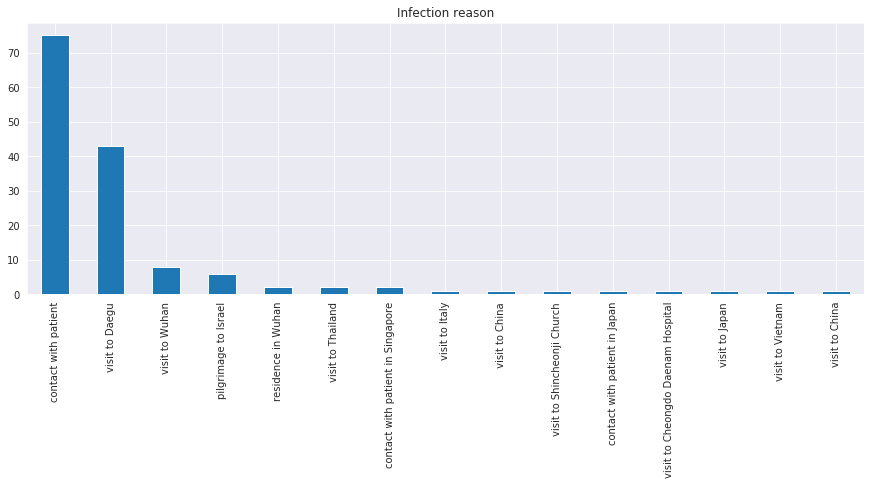

In [28]:
plt.figure(figsize=(15,5))
plt.title('Infection reason')
df_patient.infection_reason.value_counts().plot.bar();

**State of Patient**

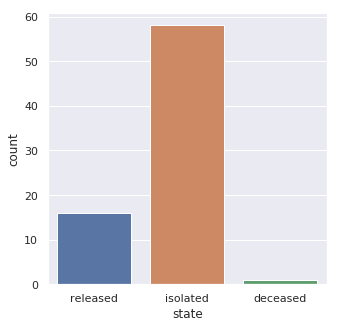

In [29]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[
    (df_patient['infection_reason']=='contact with patient')
])

**State of male patient**

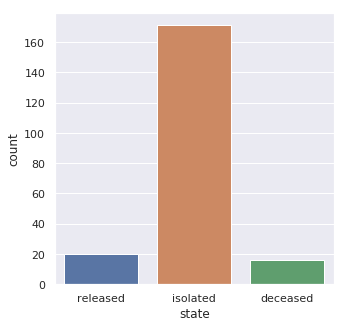

In [30]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[(df_patient['sex']=="male")])

**State of female patient**

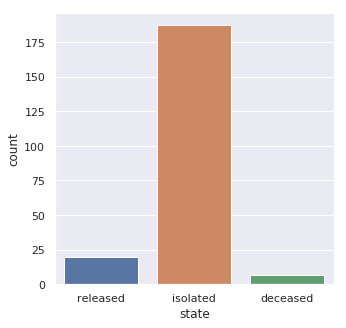

In [31]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[(df_patient['sex']=="female")])

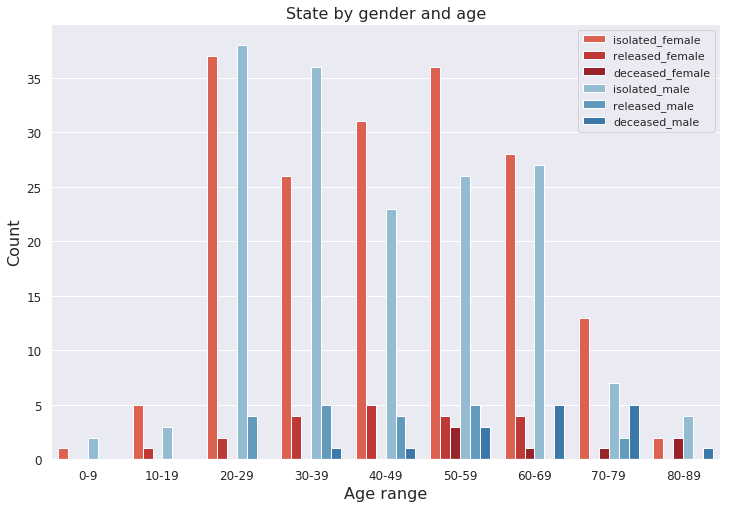

In [32]:
age_gender_hue_order =["isolated_female", "released_female", "deceased_female",
                       "isolated_male", "released_male", "deceased_male"]
custom_palette = sns.color_palette("Reds")[3:6] + sns.color_palette("Blues")[2:5]

plt.figure(figsize=(12, 8))
sns.countplot(x = "age_range",
              hue="state_by_gender",
              order=age_ranges,
              hue_order=age_gender_hue_order,
              palette=custom_palette,
              data=patient)
plt.title("State by gender and age", fontsize=16)
plt.xlabel("Age range", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper right")
plt.show()

**Looking route data**

In [33]:
df_route.head()

,id,date,province,city,visit,latitude,longitude
0,1,2020-01-19,Incheon,Jung-gu,airport,37.460459,126.440680
1,1,2020-01-20,Incheon,Seo-gu,hospital_isolated,37.478832,126.668558
2,2,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.562143,126.801884
3,2,2020-01-23,Seoul,Jung-gu,hospital_isolated,37.567454,127.005627
4,3,2020-01-20,Incheon,Jung-gu,airport,37.460459,126.440680


**Checking if is there any null value**

In [34]:
df_route.isna().sum()

id           0
date         0
province     0
city         0
visit        0
latitude     0
longitude    0
dtype: int64

In [35]:
clus=df_route.loc[:,['id','latitude','longitude']]
clus.head(10)

,id,latitude,longitude
0,1,37.460459,126.440680
1,1,37.478832,126.668558
2,2,37.562143,126.801884
3,2,37.567454,127.005627
4,3,37.460459,126.440680
5,3,37.524978,127.027718
6,3,37.503359,127.049177
7,3,37.524669,127.015911
8,3,37.529200,127.032597
9,3,37.674192,126.776955


**Checking for number of cluster**

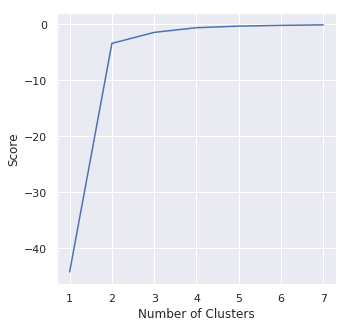

In [36]:
K_clusters = range(1,8)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df_route[['latitude']]
X_axis = df_route[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()



As in this graph, after 4 score go to constant value, so we will go with 4 clusters

In [37]:
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(clus[clus.columns[1:3]])
clus['cluster_label'] = kmeans.fit_predict(clus[clus.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(clus[clus.columns[1:3]])

**Graphical representation of clusters**

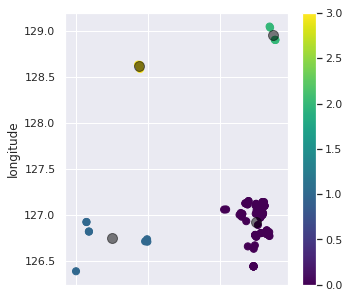

In [38]:
clus.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)


**We will verify our clusters by putting values in world map by making use of folium library**

**Affected place in world map**

In [39]:

 import folium
southkorea_map = folium.Map(location=[36.55,126.983333 ], zoom_start=7,tiles='Stamen Toner')

for lat, lon,city in zip(df_route['latitude'], df_route['longitude'],df_route['city']):
    folium.CircleMarker([lat, lon],
                        radius=5,
                        color='red',
                      popup =('City: ' + str(city) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(southkorea_map)
southkorea_map

**Patient in city**

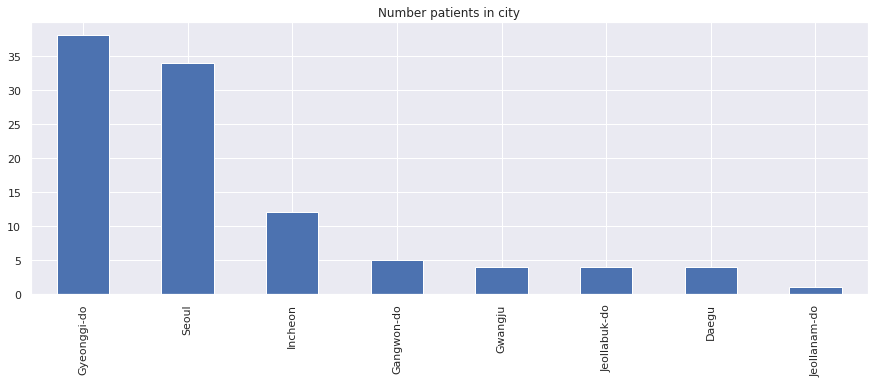

In [40]:
plt.figure(figsize=(15,5))
plt.title('Number patients in city')
df_route.province.value_counts().plot.bar();

**Patients in Provience/State**

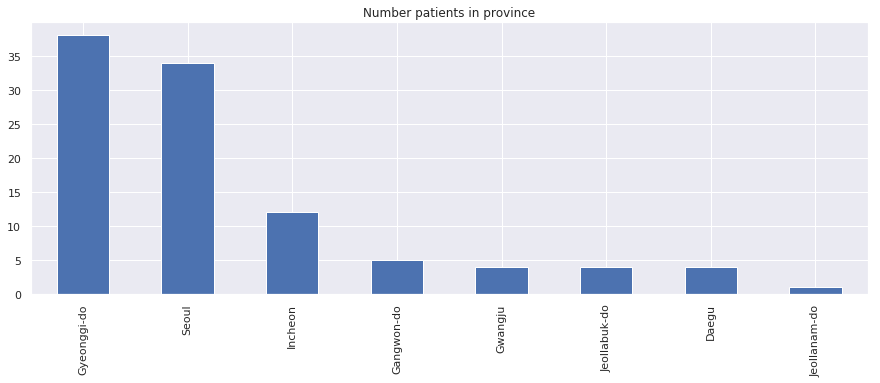

In [41]:
plt.figure(figsize=(15,5))
plt.title('Number patients in province')
df_route.province.value_counts().plot.bar();

**Places where people get affected**

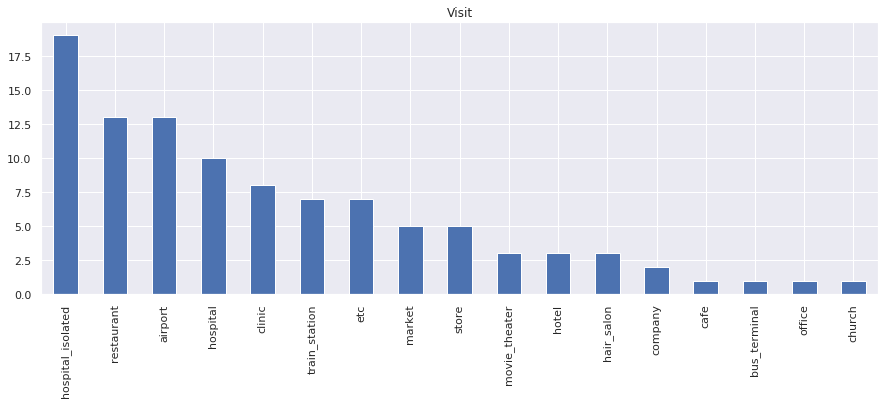

In [42]:
plt.figure(figsize=(15,5))
plt.title('Visit')
df_route.visit.value_counts().plot.bar();


**Time from confirmation to release or death**

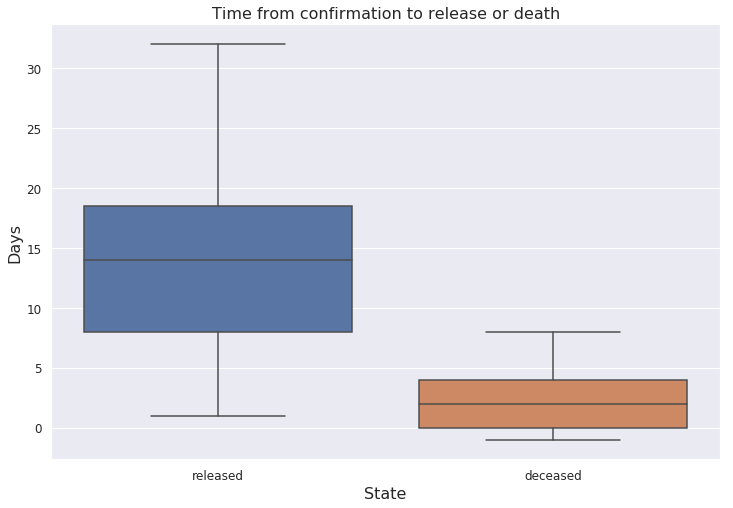

In [43]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="state",
            y="duration_days",
            order=["released", "deceased"],
            data=patient)
plt.title("Time from confirmation to release or death", fontsize=16)
plt.xlabel("State", fontsize=16)
plt.ylabel("Days", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**Making data ready for prediction**

In [44]:
data = daily_count.resample('D').first().fillna(0).cumsum()
data = data[20:]
x = np.arange(len(data)).reshape(-1, 1)
y = data.values

**Regression Model**

In [45]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=[32, 32, 10], max_iter=50000, alpha=0.0005, random_state=26)
_=model.fit(x, y)

In [46]:
test = np.arange(len(data)+7).reshape(-1, 1)
pred = model.predict(test)
prediction = pred.round().astype(int)
week = [data.index[0] + timedelta(days=i) for i in range(len(prediction))]
dt_idx = pd.DatetimeIndex(week)
predicted_count = pd.Series(prediction, dt_idx)

**Graphical representatoin of current confirmed and predicted confirmed**

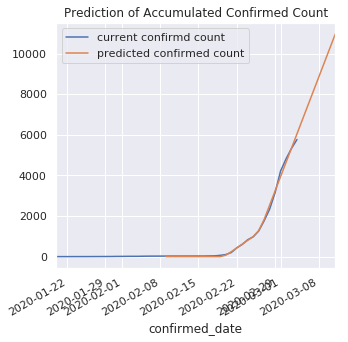

In [47]:
accumulated_count.plot()
predicted_count.plot()
plt.title('Prediction of Accumulated Confirmed Count')
plt.legend(['current confirmd count', 'predicted confirmed count'])
plt.show()

**Looking into time data**

In [48]:
df_time.head()

,date,acc_test,acc_negative,acc_confirmed,acc_released,acc_deceased,new_test,new_negative,new_confirmed,new_released,new_deceased
0,2020-01-20,1,0,1,0,0,1,0,1,0,0
1,2020-01-21,1,0,1,0,0,0,0,0,0,0
2,2020-01-22,4,3,1,0,0,3,3,0,0,0
3,2020-01-23,22,21,1,0,0,18,18,0,0,0
4,2020-01-24,27,25,2,0,0,5,4,1,0,0


**Graphical representaion of People Test and Confirmed**

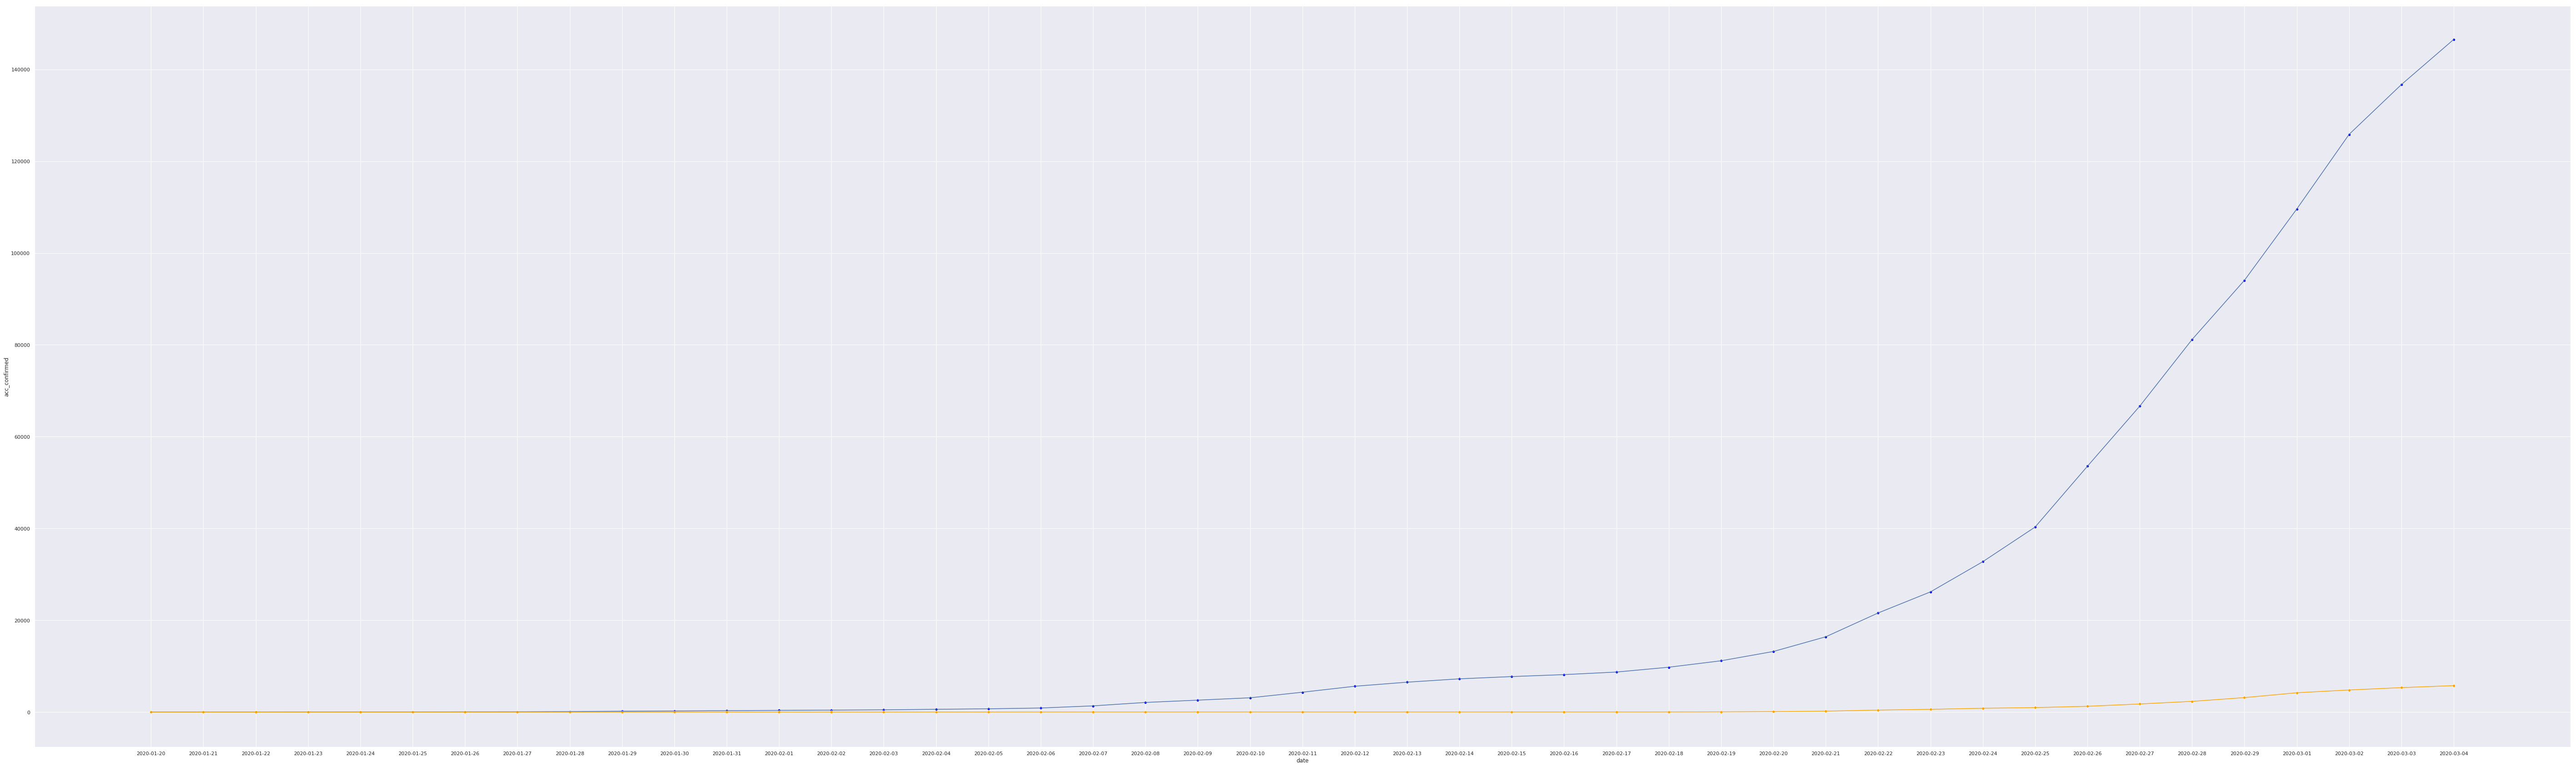

In [49]:
f, ax = plt.subplots(figsize=(100, 30))
ax=sns.scatterplot(x="date", y="acc_test", data=df_time,
             color="blue")
ax=sns.scatterplot(x="date", y="acc_confirmed", data=df_time,
             color="orange")


plt.plot(df_time.date,df_time.acc_test,zorder=1)
plt.plot(df_time.date,df_time.acc_confirmed,zorder=1,color="orange")


**Graphical representaion of People Test and Confirmed**

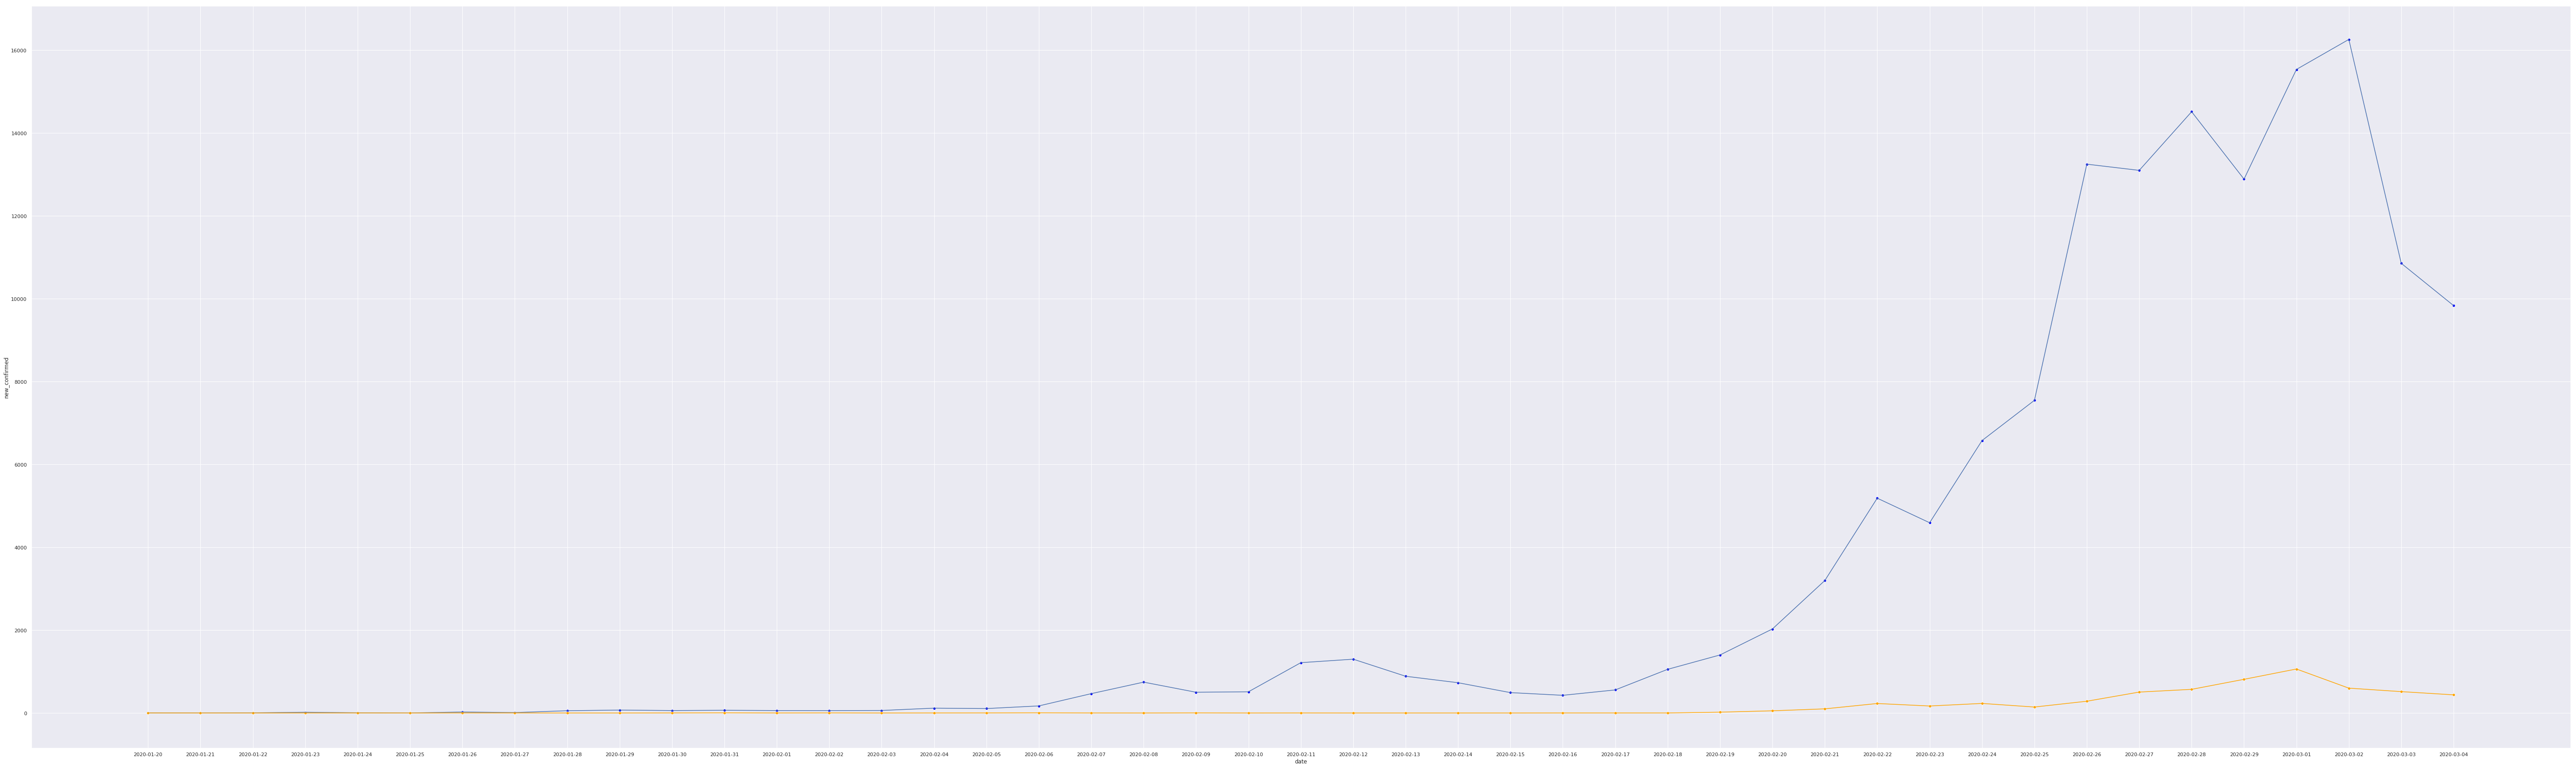

In [50]:
f, ax = plt.subplots(figsize=(100, 30))
ax=sns.scatterplot(x="date", y="new_test", data=df_time,
             color="blue")
ax=sns.scatterplot(x="date", y="new_confirmed", data=df_time,
             color="orange")


plt.plot(df_time.date,df_time.new_test,zorder=1)
plt.plot(df_time.date,df_time.new_confirmed,zorder=1,color="orange")


**Complete report on this kernel**
>[https://www.researchgate.net/publication/339738108_Analysis_Of_Coronavirus]